In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
# global setting
BATCH_SIZE = 100
NUM_CLASSES = 10
EPOCHS = 50

# Build Model 

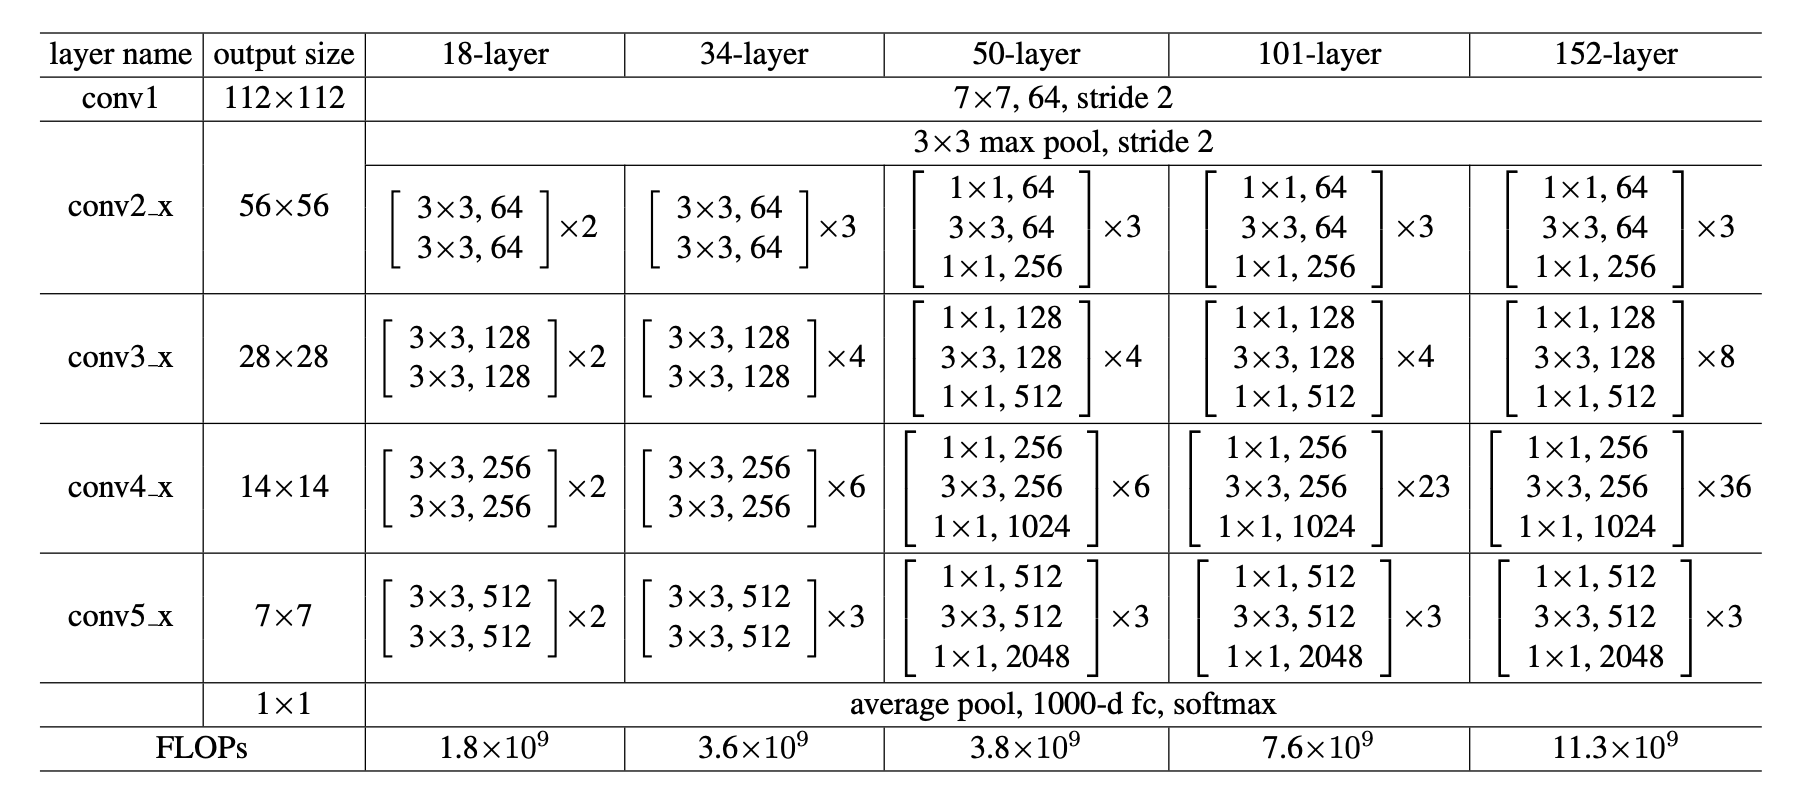

## Basic Blocks

In [ ]:
"""
block for ResNet18 and ResNet34
corresponding to the 
[3x3,num_filter]
[3x3,num_filter] 
part in Table 1

strides = 1 for 64 filters block
strides = 2 for [128, 256, 512] block (only first conv layer)
"""
class Block3x3(tf.keras.layers.Layer):
    def __init__(self, num_filter, strides):
        super().__init__()
        self.strides = strides
        self.conv1 = tf.keras.layers.Conv2D(
            filters=num_filter,
            kernel_size=[3,3],
            strides=strides,
            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(
            filters=num_filter,
            kernel_size=[3,3],
            strides=1, # strides for the second conv is 1 
            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        # functions to calcluate residual
        if strides==1:
            self.get_residual = lambda x:x
        else:
            self.get_residual = tf.keras.layers.Conv2D(
                filters=num_filter,
                kernel_size=[1,1],
                strides=strides, # size of figure shrinks with same value
                padding="same")
    
    def call(self,inputs,training=None):
        residual = self.get_residual(inputs)
        # conv nets
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        
        # output = tf.nn.relu(tf.math.add(x,residual))
        output = tf.nn.relu(tf.keras.layers.add([residual, x]))
        
        return output      

In [ ]:
"""
block for ResNet50, ResNet101, and ResNet152
"Bottle Neck Block"
"""
class BlockBottleNeck(tf.keras.layers.Layer):
    def __init__(self,num_filter1,strides):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=num_filter1,
            kernel_size=[1, 1],
            padding="same",
            strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(
            filters=num_filter1,
            kernel_size=[3, 3],
            padding="same",
            strides=1)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(
            filters=num_filter1*4,
            kernel_size=[1, 1],
            padding="same",
            strides=1)
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        self.get_residual = tf.keras.layers.Conv2D(
            filters=num_filter1*4,
            kernel_size=[1, 1],
            padding="same",
            strides=strides)
    
    def call(self,inputs, training=None):
        residual = self.get_residual(inputs)
        
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = tf.math.add(x, residual)
        
        output = tf.nn.relu(x)
        
        return output

## Blocks with the Same num_filter

In [ ]:
"""
block for ResNet18 and ResNet34
corresponding to the 
[3x3,num_filter]
[3x3,num_filter] x 2 
part in Table 1 (one cell in table)
"""
class Block3x3xn(tf.keras.layers.Layer):
    def __init__(self, num_filter, num_block, strides):
        super().__init__()
        self.num_block = num_block
        self.block1 = Block3x3(num_filter, strides) # could have stride
        self.block_after2_list = []
        for i in range(num_block-1):
            self.block_after2_list.append(Block3x3(num_filter,1))
            
    def call(self, inputs, training=None):
        x = self.block1(inputs, training=training)
        for i in range(self.num_block-1):
            x = self.block_after2_list[i](x, training=training)
        output = x
        
        return output

In [ ]:
"""
for ResNet50+
"""
class BlockBottleNeckxn(tf.keras.layers.Layer):
    def __init__(self,num_filter1, num_block,strides):
        super().__init__()
        self.num_block = num_block
        self.block1 = BlockBottleNeck(num_filter1, strides)
        self.block_after2_list = []
        for i in range(num_block-1):
            self.block_after2_list.append(BlockBottleNeck(num_filter1, strides))
            
    def call(self, inputs, training=None):
        x = self.block1(inputs)
        for i in range(self.num_block-1):
            x = self.block_after2_list[i](x, training=training)
        output = x
        
        return output      

## Model Classes

In [ ]:
# ResNet18 class
class ResNet18(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=[7, 7],
            strides=2,
            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.maxpooling1 = tf.keras.layers.MaxPool2D(
            pool_size=[3, 3],
            strides=2,
            padding="same")
        # num_filter, num_block, stride for 1st conv layer
        self.block1 = Block3x3xn(64, 2, 1)
        self.block2 = Block3x3xn(128, 2, 2)
        self.block3 = Block3x3xn(256, 2, 2)
        self.block4 = Block3x3xn(512, 2, 2)
        # average pooling 
        self.averagepooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(units=NUM_CLASSES) # number of classes
    
    def call(self, inputs, training=None):
        x = tf.image.resize(inputs,[224, 224])
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.maxpooling1(x)
        x = self.block1(x, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.block4(x, training=training)
        x = self.averagepooling(x)
        x = self.dense(x)
        output = tf.nn.softmax(x)
        
        return output  

In [ ]:
# ResNet34 class
class ResNet34(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=[7, 7],
            strides=2,
            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.maxpooling1 = tf.keras.layers.MaxPool2D(
            pool_size=[3, 3],
            strides=2,
            padding="same")
        # filters, num_block, strides
        self.block1 = Block3x3xn(64, 3, 1)
        self.block2 = Block3x3xn(128, 4, 2)
        self.block3 = Block3x3xn(256, 6, 2)
        self.block4 = Block3x3xn(512, 3, 2)
        self.averagepooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(units=NUM_CLASSES)
        
    def call(self, inputs, training=None):
        x = tf.image.resize(inputs, [224, 224])
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.maxpooling1(x)
        x = self.block1(x, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.block4(x, training=training)
        x = self.averagepooling(x)
        x = self.dense(x)
        output = tf.nn.softmax(x)
        
        return output  

In [ ]:
# ResNet50 class
class ResNet50(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=[7, 7],
            strides=2,
            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.maxpooling1 = tf.keras.layers.MaxPool2D(
            pool_size=[3, 3],
            strides=2,
            padding="same")
        # filters, num_block, strides
        self.block1 = BlockBottleNeckxn(64, 3, 1)
        self.block2 = BlockBottleNeckxn(128, 4, 2)
        self.block3 = BlockBottleNeckxn(256, 6, 2)
        self.block4 = BlockBottleNeckxn(512, 3, 2)
        self.averagepooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(units=NUM_CLASSES)
        
    def call(self, inputs, training=None):
        x = tf.image.resize(inputs, [224, 224])
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.maxpooling1(x)
        x = self.block1(x, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.block4(x, training=training)
        x = self.averagepooling(x)
        x = self.dense(x)
        
        output = tf.nn.softmax(x)
        
        return output  

## Model Selcetion

In [ ]:
# model = ResNet18()
model = ResNet34()
# model = ResNet50()

# Data: CIFAR10

In [ ]:
# load data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train = X_train/255.
X_test = X_test/255.
# one-hot coding
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

## Data Augmentation

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Compile

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss=tf.keras.losses.sparse_categorical_crossentropy,
    loss=tf.keras.losses.categorical_crossentropy,
#     metrics=[tf.keras.metrics.sparse_categorical_accuracy])
    metrics=[tf.keras.metrics.categorical_accuracy])

# Fit

In [ ]:
model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),steps_per_epoch=len(X_train)/BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test))

# Evaluate

In [ ]:
model.evaluate(X_test, y_test)

# Reference  
[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)